In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

In [0]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

In [0]:
# Common imports
import numpy as np
import os

In [0]:
# To plot pretty figures directly within Jupyter
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [0]:
# Get Data
import os
import tarfile
import urllib
import csv

DOWNLOAD_ROOT = "https://archive.ics.uci.edu/ml/machine-learning-databases/"
WINE_PATH = os.path.join("datasets", "wine")
WINE_URL = DOWNLOAD_ROOT + "wine/"

def fix_wine_data(file):
  attributes = [
                "Class",
                "Alcohol", 
                "Malic acid", 
                "Ash", 
                "Alcalinity of ash",
                "Magnesium",
                "Total phenols",
                "Flavanoids",
                "Nonflavanoid phenols",
                "Proanthocyanins",
                "Color intensity",
                "Hue",
                "OD280/OD315 of diluted wines",
                "Proline"
                ]
  with open(file, "r") as inf:
    reader = list(csv.reader(inf))
    reader.insert(0, attributes)

  with open(file, "w") as outf:
    writer = csv.writer(outf)
    for row in reader:
        writer.writerow(row)

def fetch_wine_data(wine_url=WINE_URL, wine_path=WINE_PATH):
    if not os.path.isdir(wine_path):
        os.makedirs(wine_path)
    wine_csv_path = os.path.join(wine_path, "wine.csv")
    urllib.request.urlretrieve(wine_url + "wine.data", wine_csv_path)
    wine_names_path = os.path.join(wine_path, "wine.names")
    urllib.request.urlretrieve(wine_url + "wine.names", wine_names_path)
    fix_wine_data(wine_csv_path)

In [0]:
fetch_wine_data()

In [0]:
import pandas as pd

def load_wine_data(wine_path=WINE_PATH):
    csv_path = os.path.join(wine_path, "wine.csv")
    return pd.read_csv(csv_path)

In [127]:
wine = load_wine_data()
wine.head()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [128]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
Class                           178 non-null int64
Alcohol                         178 non-null float64
Malic acid                      178 non-null float64
Ash                             178 non-null float64
Alcalinity of ash               178 non-null float64
Magnesium                       178 non-null int64
Total phenols                   178 non-null float64
Flavanoids                      178 non-null float64
Nonflavanoid phenols            178 non-null float64
Proanthocyanins                 178 non-null float64
Color intensity                 178 non-null float64
Hue                             178 non-null float64
OD280/OD315 of diluted wines    178 non-null float64
Proline                         178 non-null int64
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


In [129]:
wine["Alcohol"].value_counts()

12.37    6
13.05    6
12.08    5
12.29    4
12.00    3
        ..
13.34    1
13.69    1
13.90    1
13.84    1
13.75    1
Name: Alcohol, Length: 126, dtype: int64

In [130]:
wine.describe()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


Saving figure attribute_histogram_plots


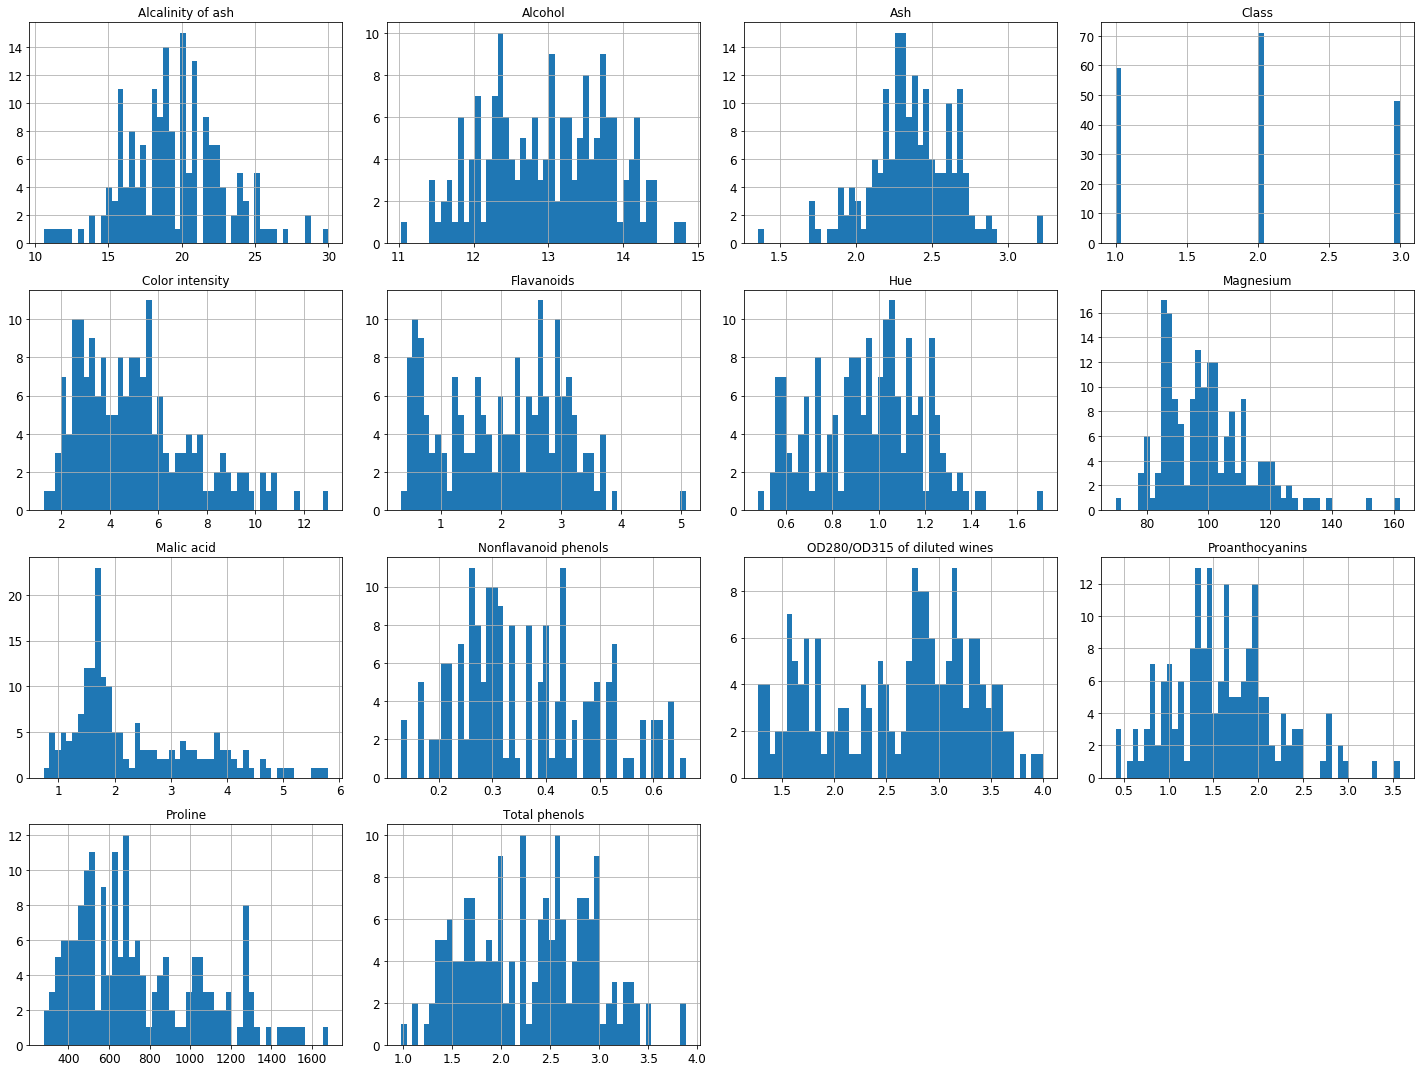

In [131]:
%matplotlib inline
import matplotlib.pyplot as plt
wine.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

In [0]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [0]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [134]:
train_set, test_set = split_train_test(wine, 0.2)
len(train_set)

143

In [135]:
len(test_set)

35

In [0]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [0]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

In [0]:
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [0]:
wine_with_id = wine.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(wine_with_id, 0.2, "index")

In [0]:
wine_with_id["id"] = wine["Alcohol"] * 1000 + wine["Malic acid"]
train_set, test_set = split_train_test_by_id(wine_with_id, 0.2, "id")

In [141]:
test_set.head()

,index,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,id
6,6,1,14.39,1.87,2.45,14.6,96,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290,14391.87
8,8,1,14.83,1.64,2.17,14.0,97,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045,14831.64
13,13,1,14.75,1.73,2.39,11.4,91,3.10,3.69,0.43,2.81,5.40,1.25,2.73,1150,14751.73
15,15,1,13.63,1.81,2.70,17.2,112,2.85,2.91,0.30,1.46,7.30,1.28,2.88,1310,13631.81
22,22,1,13.71,1.86,2.36,16.6,101,2.61,2.88,0.27,1.69,3.80,1.11,4.00,1035,13711.86


In [0]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(wine, test_size=0.2, random_state=42)

In [143]:
test_set.head()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
19,1,13.64,3.10,2.56,15.2,116,2.70,3.03,0.17,1.66,5.10,0.96,3.36,845
45,1,14.21,4.04,2.44,18.9,111,2.85,2.65,0.30,1.25,5.24,0.87,3.33,1080
140,3,12.93,2.81,2.70,21.0,96,1.54,0.50,0.53,0.75,4.60,0.77,2.31,600
30,1,13.73,1.50,2.70,22.5,101,3.00,3.25,0.29,2.38,5.70,1.19,2.71,1285
67,2,12.37,1.17,1.92,19.6,78,2.11,2.00,0.27,1.04,4.68,1.12,3.48,510
